# Take a single image

Learn how to generate a single image.

## Imports

In [1]:
import numpy as np

import synpivimage

## Set up the synthetic PIV components
A synthetic PIV setup consists of

- [laser](Laser.ipynb) and
- [camera](Camera.ipynb).

Let's set up both components. If you need explanation for the parameters, please visit the documentation for [laser](Laser.ipynb) and [camera](Camera.ipynb) respectively.

We will use some standard parameters and choose a small image/sensor of 16x16 pixels:

In [2]:
cam = synpivimage.Camera(
    nx=16,
    ny=16,
    bit_depth=16,
    qe=1,
    sensitivity=1,
    baseline_noise=50,
    dark_noise=10,
    shot_noise=False,
    fill_ratio_x=1.0,
    fill_ratio_y=1.0,
    particle_image_diameter=2,
    seed=100
)

laser = synpivimage.Laser(
    width=0.25,
    shape_factor=2
)

## Position particles

Next, we need to define the position and size of the **particles** within the sensor plane.

**By intention**, we create particles *outside* the camera FOV, which are coordinates below 0 or larger than `cam.nx` or `cam.ny`. By taking the image later, the algorithm will flag particles, that are not illuminated. 

In [3]:
n = 100
particles = synpivimage.Particles(
    x=np.random.uniform(-5, cam.nx+4, n),
    y=np.random.uniform(-5, cam.ny+4, n),
    z=np.zeros(n),
    size=np.ones(n)*2.5
)

## Take the image

To take the image, call `take_image` and pass the above components. You need to define the theoretical particle count of an image particle located at z=0.

In [4]:
img, part = synpivimage.take_image(
    laser,
    cam,
    particles,
    particle_peak_count=1000)

Let's plot the image. Not all particles are illuminated. We will mark the illuminated ones green in the plot below. All illuminated (active) particles can be accessed using the flag via the property `active`:

In [5]:
import matplotlib.pyplot as plt

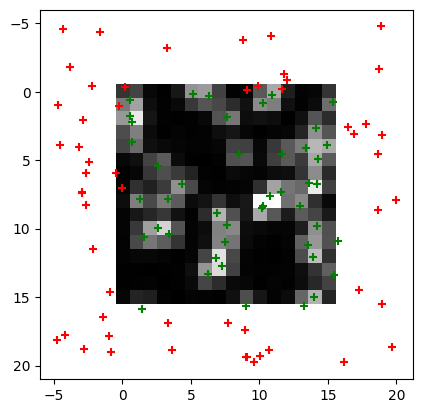

In [6]:
plt.imshow(img, cmap='gray')
plt.scatter(part.x[part.active],
            part.y[part.active],
            marker='+', color='g')
plt.scatter(part.x[~part.active],
            part.y[~part.active],
            marker='+', color='r')

## Save the image and the setup

We save the image including the camera and laser settings like this:

In [7]:
with synpivimage.Imwriter(case_name='single_img',
                          image_dir='.',
                          suffix='.tif',
                          overwrite=True,
                          camera=cam,
                          laser=laser) as iw:
    iw.write(0, img, particles=part)

Note: If the image needs to be indicated as an *A* or *B* image, use `writeA` or `writeB` instead of `write`.

### Write to HDF5

In [8]:
import h5rdmtoolbox as h5tbx

In [11]:
with synpivimage.HDF5Writer(filename='single_img.hdf',
                            n_images=1,
                            camera=cam,
                            laser=laser,
                            overwrite=True) as h5:
    h5.writeA(0, img, particles=part)
    h5.writeA(0, img, particles=part)

h5tbx.dump('single_img.hdf')

## Read data

The image can be read with `cv2`. The settings and particles can be read with `synpivimage`. Note, that the latter is stored as json-ld files, which allow anyone (human or machine) to read the data. The keys in the json document are put into context. More on this [here](https://json-ld.org/).

### Read image

To read the image data if stored as tif file, just use the open-cv package:

In [12]:
import cv2

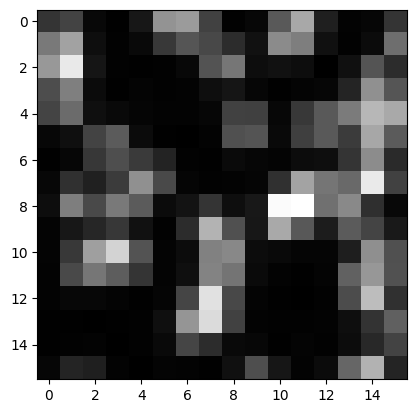

In [13]:
img_loaded = cv2.imread('single_img/imgs/img_000000.tif', -1)
plt.imshow(img_loaded, cmap='gray')

If data is stored in the HDF5 file, use `h5py` or `h5tbx`:

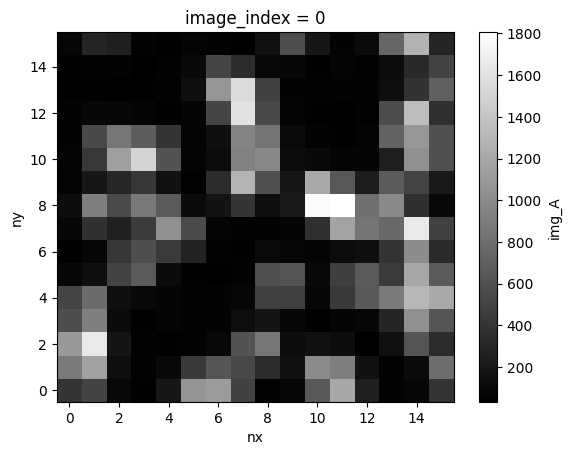

In [16]:
with h5tbx.File('single_img.hdf') as h5:
    imgAloaded = h5.images.img_A[()]
imgAloaded.plot(cmap='gray')

### Read the setup

The setup can be stored in JSON files (actually JSON-LD files, but the suffix is .json). If you wrote data to HDF5, then simply read the datasets "camera" and "laser" with their attribute.

In the following we will learn how to extract the data from the JSON-LD files using `ontolutils`

In [21]:
loaded_laser = synpivimage.Laser.load_jsonld('single_img/laser.json')
loaded_camera = synpivimage.Camera.load_jsonld('single_img/camera.json')

**Experts:** If you want to know how it is done, the following parts will show, what is going on behind `load_jsonld`:

In the background the `rdflib` library is used query the json-ld file with SPARQL. The library `ontolutils` further helps us with that and returns a dictionary for the type of thing we are looking for. For the laser, we are searching for types "pivmeta:LaserModel":

In [22]:
import ontolutils

In [23]:
query_dict = ontolutils.dquery(
    'pivmeta:LaserModel',
    'single_img/laser.json',
    context={'pivmeta': 'https://matthiasprobst.github.io/pivmeta#'}
)

for p in query_dict[0]['hasParameter']:
    print(f"{p['label']:14s}: {p['hasNumericalValue']} (std name: {p['hasStandardName']})")

width         : 0.25 (std name: https://matthiasprobst.github.io/pivmeta#model_laser_sheet_thickness)
shape_factor  : 2 (std name: https://matthiasprobst.github.io/pivmeta#model_laser_sheet_shape_factor)


Note: Theoretically, there might be many lasers stored in the JSON file, this is why we get a list of dictionaries!

More useful than the above is retrieving the parameters as a dictionaries with the label as key (the label turns out to be exactly the object attributes of our components).

In [24]:
params = {p['label']: p.get('hasNumericalValue', p.get('hasStringValue', None)) for p in query_dict[0]['hasParameter']}
params

{'width': '0.25', 'shape_factor': '2'}

In the next step we can pass this to out component, in this case the laser:

In [25]:
synpivimage.Laser(**params)

Laser(shape_factor=2, width=0.25)